# K-means

## create fake data

In [1]:
import math
import numpy as np
import pandas as pd
np.random.seed(123)

def circulo(num_datos = 100,R = 1, minimo = 0,maximo= 1, center_x = 0 , center_y = 0):
    pi = math.pi
    r = R * np.sqrt(np.random.uniform(minimo, maximo, size = num_datos)) 
    theta = np.random.uniform(minimo, maximo, size= num_datos) * 2 * pi

    x = center_x + np.cos(theta) * r
    y = center_y + np.sin(theta) * r

    x = np.round(x,3)
    y = np.round(y,3)

    df = np.column_stack([x,y])
    df = pd.DataFrame(df)
    df.columns = ['x','y']
    return(df)

# Create data
datos_1 = circulo(num_datos = 20,R = 10, center_x = 5, center_y = 30)
datos_2 = circulo(num_datos = 20,R = 10, center_x = 20, center_y = 10)
datos_3 = circulo(num_datos = 20,R = 10, center_x = 50, center_y = 50)

data = datos_1.append(datos_2).append(datos_3)
data.head()

,x,y
0,-0.542,23.761
1,8.129,25.661
2,4.239,25.298
3,-0.691,25.230
4,3.539,21.645


In [2]:
original_data = data

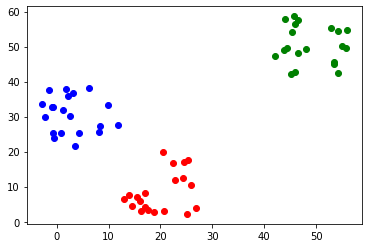

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(datos_1['x'], datos_1['y'], c = 'b')
plt.scatter(datos_2['x'], datos_2['y'], c = 'r')
plt.scatter(datos_3['x'], datos_3['y'], c = 'g')
plt.show()

## K-means from scratch

### initialize centroids

In [4]:
def initialize_centroids(k, data):
    dim = data.shape[1]
    centr_min = data.min()
    centr_max = data.max()
    
    centroids = []
    
    for _ in range(k):
        centroid = np.random.uniform(centr_min, centr_max, dim)
        centroids.append(centroid)
    
    centroids = pd.DataFrame(centroids, columns = data.columns)
    
    return centroids

centroids = initialize_centroids(3, data)
centroids

,x,y
0,50.303864,13.933930
1,14.350891,31.562773
2,50.102631,57.727209


### Calculate error

In [5]:
def cal_error(a, b):
    # calculate distance between two points: a, b
    error = np.square(np.sum((a-b)**2))
    
    return error

In [6]:
# Example
point = data.iloc[0,:2]
print(point)

errors = np.array([])
for i in range(centroids.shape[0]):
    centroid = centroids.iloc[i, :2]
    error = cal_error(point, centroid)
    errors = np.append(errors, error)

print(errors)

x    -0.542
y    23.761
Name: 0, dtype: float64
[ 7192443.57624208    79899.99749005 13827851.8644529 ]


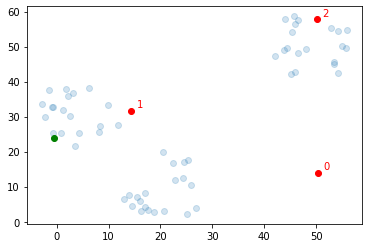

In [7]:
plt.scatter(data.iloc[1:,0], data.iloc[1:,1],  marker = 'o', alpha = 0.2)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', c = 'r')
plt.scatter(point[0], point[1],  marker = 'o', c = 'g')
for i in range(centroids.shape[0]):
    plt.text(centroids.iloc[i,0]+1, centroids.iloc[i,1]+1, s = centroids.index[i], c = 'r')

In [8]:
# locate the min error's index
np.where(errors == np.amin(errors, 0))[0].tolist()[0]

1

## Assign centroid to each point

In [9]:
def assign_centroid(data, centroids):
    num_data = data.shape[0]
    k = centroids.shape[0]
    centroid_assign = []
    centroid_errors = []
    
    for i in range(num_data):
        errors = np.array([])
        node = data.iloc[i, :2]
        for j in range(k):
            error = cal_error(node, centroids.iloc[j, :2])
            errors = np.append(errors, error)
            
        centroid_error = np.amin(errors, 0)
        closest_centroid = np.where(errors == centroid_error)[0].tolist()[0]
        
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)
    
    return (centroid_assign, centroid_errors)

data['centroid'], data['error'] = assign_centroid(data.iloc[:,:2] ,centroids)
data[['centroid', 'error']].head()

,centroid,error
0,1,79899.997490
1,1,5408.551819
2,1,20021.607118
3,1,70948.987085
4,1,46336.530388


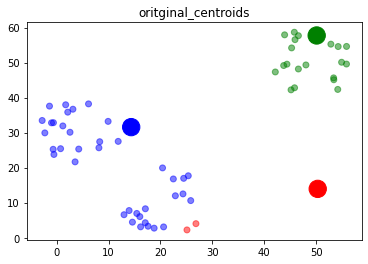

In [10]:
colors = {0:'red', 1:'blue', 2:'green'}
plt.title('oritginal_centroids')
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

In [11]:
data['error'].sum()

8896533.553262657

In [12]:
data_columns = ['x', 'y']

new_centroids = data.groupby('centroid').agg('mean').loc[:, data_columns].reset_index(drop = True)
print('original centroids\n', centroids)
print('new centroids\n', new_centroids)

original centroids
            x          y
0  50.303864  13.933930
1  14.350891  31.562773
2  50.102631  57.727209
new centroids
            x          y
0  25.966500   3.109000
1  10.528579  20.395105
2  48.898800  50.526050


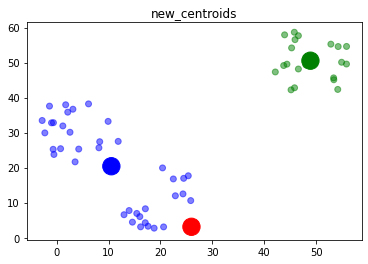

In [13]:
plt.title('new_centroids')
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(new_centroids.iloc[:,0], new_centroids.iloc[:,1],  marker = 'o', s=300, 
           c = new_centroids.index.map(lambda x: colors[x]))

## Putting all together K-means algorithm

In [14]:
def knn(data, k):
    '''
    Given a dataset and number of clusters, it clusterizes the data. 
    data: a DataFrame with all information necessary
    k: number of clusters to create
    '''

    # Initialize centroids and error
    centroids = initialize_centroids(k, data)
    error = []
    compr = True
    i = 0

    while(compr):
        # Obtain centroids and error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error.append(sum(iter_error))
        print('iteration %d error: %d' %(i, error[-1]))
        # Recalculate centroids
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Check if the error has decreased
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                compr = True
            else:
                compr = False
        i = i + 1 

    data['centroid'], iter_error = assign_centroid(data,centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)
    return (data['centroid'], iter_error, centroids)

In [15]:
data['centroid'], _, centroids =  knn(data.drop(['centroid','error'], axis = 1),3)
data['centroid'].head()  

iteration 0 error: 17965401
iteration 1 error: 205885
iteration 2 error: 175816
iteration 3 error: 175816


0    0
1    0
2    0
3    0
4    0
Name: centroid, dtype: int64